In [3]:
# Set up environment & imports
import sys
import os

# Add root folder to Python path (so we can import config.py)
sys.path.append(os.path.abspath('..'))

# Import config
from config import RAW_DATA, MODELS_DIR

# Core libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. Load dataset
df = pd.read_csv(RAW_DATA)

# Normalize column names for consistency
df.columns = df.columns.str.lower()
df.head()


,breed,weight,chest,neck,bootsize,age,activity,harnesssize
0,Boxer,28.8,70.8,42.2,6,64.0,High,L
1,Boxer,30.8,67.6,41.5,3,55.0,Medium,L
2,Poodle,23.0,53.2,37.5,6,69.0,High,M
3,Boxer,29.4,70.8,37.8,6,26.0,Medium,L
4,Beagle,11.5,48.4,39.3,1,NaN,High,S


In [11]:
# Define featuers and target
# Target variable
y = df['harnesssize']

# Features (exclude target)
X = df.drop('harnesssize', axis=1)

# Identify categorical & numeric columns
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

Categorical features: ['breed', 'activity']
Numeric features: ['weight', 'chest', 'neck', 'bootsize', 'age']


In [12]:
# Train/Test Split

from sklearn.model_selection import train_test_split

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 8160
Testing samples: 2040


In [13]:
# Preprocessing and Pipeline Setup
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # keep numeric columns as-is
)

# Linear Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Pipeline ready for training!")

Pipeline ready for training!


In [14]:
# Mapping Haness Sizes To Numeric Values
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)  # No encoding needed
y_pred_rf = rf_pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.9921568627450981


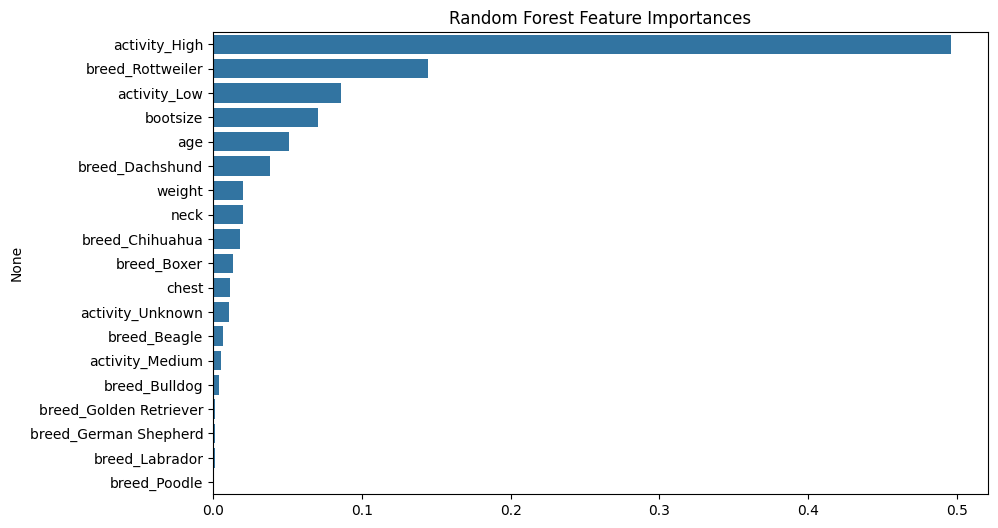

In [15]:
# numeric features
feature_names = numeric_features.copy()

# get the OneHotEncoder directly from the preprocessor
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# get categorical feature names
cat_feature_names = ohe.get_feature_names_out()  # no input argument needed if already fitted

# combine
feature_names += list(cat_feature_names)

# get feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest Feature Importances")
plt.show()


In [18]:
# Saving Trained Model
import joblib
joblib.dump(rf_pipeline, '../models/rf_harness_model.pkl')
print("Model saved to ../models/rf_harness_model.pkl")


Model saved to ../models/rf_harness_model.pkl
